# Define your ouwn data generator    
## It choses a batch of images from the training data folder
## It applies augmentation on each of the images
## It crops a random patch from each of the augmented data, following a certain pdf distribution (if given)

    

In [1]:
import numpy as np
import SimpleITK as sitk
import keras
from keras.preprocessing.image import ImageDataGenerator
keras.__version__
# Follow: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly


## Define random crop function

def random_crop(x, y, random_crop_size_input, random_crop_size_output, pdf=None, sync_seed=None):
    # x is 3D data but patches are only cropped in 2D. x dimensions (z,x,y)
    # pdf is a 2D image representing the sampling distribution to crop the patches. pdf dimensions (x,y)
    np.random.seed(sync_seed)
    w, h = x.shape[1], x.shape[2]

#     rangew = (w - random_crop_size[0])
#     rangeh = (h - random_crop_size[1])
    rangew = (w - np.floor(random_crop_size_input[0]//2))
    rangeh = (h - np.floor(random_crop_size_input[1]//2))
#     offsetw = 0 if rangew == 0 else np.random.randint(rangew)
#     offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    if pdf is None:
        offsetw = np.random.randint(np.floor(random_crop_size_input[0]//2), rangew)
        offseth = np.random.randint(np.floor(random_crop_size_input[1]//2), rangeh)
    else:
        l = np.int(np.floor(random_crop_size_input[0]//2))
        u = np.int(np.floor(random_crop_size_input[1]//2))
        pdf = pdf[l:-l,u:-u]
        prob = np.float32(pdf)
        prob = prob.ravel()/np.sum(prob)
        choices = np.prod(pdf.shape)
        index = np.random.choice(choices, size=1,p = prob)
        coordinates = np.unravel_index(index, dims=pdf.shape)
        offsetw = coordinates[0][0] # pdf first coordinate corresponds to the "x" axis = width
        offsetw = offsetw + l
        offseth = coordinates[1][0] # pdf second coordinate corresponds to the "y" axis = height
        offseth = offseth + u
    
    lr = offsetw-np.floor(random_crop_size_input[0]//2)
    lr = lr.astype(np.int)
    ur = offsetw+np.round(random_crop_size_input[0]//2)
    ur = ur.astype(np.int)
    
    lc = offseth-np.floor(random_crop_size_input[1]//2)
    lc = lc.astype(np.int)
    uc = offseth+np.round(random_crop_size_input[1]//2)
    uc = uc.astype(np.int)
    
    x_patch = x[:, lr:ur,lc:uc]
    
    y_patch = y[:, lr:ur,lc:uc]
    y_patch=center_crop(y_patch, random_crop_size_output)
    
    
#     lr = offsetw-np.floor(random_crop_size_output[0]//2)
#     lr = lr.astype(np.int)
#     ur = offsetw+np.round(random_crop_size_output[0]//2)
#     ur = ur.astype(np.int)
    
#     lc = offseth-np.floor(random_crop_size_output[1]//2)
#     lc = lc.astype(np.int)
#     uc = offseth+np.round(random_crop_size_output[1]//2)
#     uc = uc.astype(np.int)
    
    
    return x_patch, y_patch
    
def center_crop(x, crop_size):
    # Crop function when there is no padding in the the CNN and we need to reduce the ground truth. 
    # x is 3D data but patches are only cropped in 2D. x dimensions (z,y,x)
    
    halfw = (x.shape[1]-crop_size[0])//2
    halfh = (x.shape[2]-crop_size[1])//2

    return x[:, halfw:-halfw,halfh:-halfh] 


## Define data augmentation for the case in which x has dimensions (t,i,j) and y (1,i,j). 
# The output of this function are augmented_x with dimensions (1,t,i,j,c) and augmented_y with (1,1,i,j,c)

def data_augmentation_timeseries(x, y, self, seed = None):
      
    data_gen_args = dict(rotation_range=self.rotation_range,
                            width_shift_range=self.width_shift_range,
                            height_shift_range=self.height_shift_range,
                            shear_range=self.shear_range,
                            zoom_range=self.zoom_range,
                            horizontal_flip=self.horizontal_flip,
                            fill_mode=self.fill_mode) 

    # Initialize Keras data augmentaiton
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    #   Apply the same data augmentation to all the images of the video, corresponding mask and pdf for crop
    # self.dim_input=(220,220,21)

    input_channel = np.zeros((1,self.dim_input[2],self.dim_input[0], self.dim_input[1],  self.n_channels))
    output_channel = np.zeros((1,self.dim_output[2], self.dim_output[0], self.dim_output[1], self.n_channels))
    
    
    # Generate the same seed:
    seed = np.random.randint(10000000)
    for c in range(self.n_channels):        
        if self.module == "Train":
            augmented_x = np.zeros((x.shape[0], x.shape[1], x.shape[2]))
#             augmented_y = np.zeros((y.shape[0], y.shape[1], y.shape[2]))
            
            self_pdf = self.pdf
            
            if self_pdf == None:
                self_pdf = np.ones((x.shape[1], x.shape[2]))
            augmented_pdf = np.zeros((1,self_pdf.shape[0], self_pdf.shape[1], 1))
    
            for t in range(input_channel.shape[1]):
                aux = x[t,:,:]
                aux = aux.reshape((1, x.shape[1], x.shape[2]))
                aux = aux.reshape((1, x.shape[1], x.shape[2], 1))
                
                for batch in image_datagen.flow(aux,  batch_size=1, seed = seed):
                    augmented_x[t,:,:] = batch[0,:,:,0]
                    break

            # Apply the same data augmentation to the ground truth. 
            # GROUND TRUTH IS ASSUMED TO BE 2D
            # self.dim_output=(36,36,1)
            # output_channel.dimensions = (1,36,36)
            aux_y = np.copy(y)
            aux_y = aux_y.reshape((1, y.shape[1], y.shape[2], 1))
            for batch in mask_datagen.flow(aux_y,  batch_size=1, seed = seed):
                augmented_y = batch[:,:,:,0]
                break
            aux_pdf = np.copy(self_pdf)
            aux_pdf = aux_pdf.reshape((1, self_pdf.shape[0], self_pdf.shape[1]))
            aux_pdf = aux_pdf.reshape((1, self_pdf.shape[0], self_pdf.shape[1],1))
            for batch in mask_datagen.flow(aux_pdf,  batch_size=1, seed = seed):
                augmented_pdf = batch
                break
        augmented_y[augmented_y>0]=1        
        random_crop_size_input = (self.dim_input[0],  self.dim_input[1])
        random_crop_size_output = (self.dim_output[0],  self.dim_output[1])
        input_channel[0,:,:,:,c],output_channel[0,:,:,:,c] = random_crop(augmented_x,augmented_y, random_crop_size_input, random_crop_size_output, pdf=augmented_pdf[0,:,:,0], sync_seed=seed)

    return input_channel, output_channel




# Follow: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

## Define DataGenerator 


class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,list_IDs, dataset_path, rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range, horizontal_flip, fill_mode, dim_input=None, dim_output=None, pdf = None, module = "Train", patch_batch=10, batch_size=1, n_channels=1, shuffle=True):
        # Suffle is used to take everytime a different sample from the list in a random way so the training order differs. 
        #     # we create two instances with the same arguments
        # 'Initialization'

            
        self.list_IDs = list_IDs
        
#         if module=='Train':
#             self.dataset_path = '../data/training/'
#         else:
#             self.dataset_path = '../data/test/'

        self.dataset_path = dataset_path   
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        
        self.fill_mode = fill_mode       
        self.pdf = pdf
        self.module = module # "Train" or "Test"        
#         self.data_format = data_format
        if dim_input == None:
            dim_input =(220,220,21)
        if dim_output == None:
            dim_output=(36,36,1)
        self.dim_input = dim_input
        self.dim_output = dim_output
        self.patch_batch = patch_batch
        self.batch_size = batch_size
        
        self.n_channels = n_channels
        self.shuffle = shuffle # #
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        x,y = self.__data_generation(list_IDs_temp)
        return x,y   
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)    
    # crop patches

    def __data_generation(self, list_IDs_temp):
        
        # 'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialization
        x = np.empty((self.batch_size*self.patch_batch, self.dim_input[0],  self.dim_input[1],  self.dim_input[2], self.n_channels))
        y = np.empty((self.batch_size*self.patch_batch, self.dim_output[0],  self.dim_output[1],  self.dim_output[2], self.n_channels))

        # Generate data
        j = 0
        for patch in range(self.patch_batch):            
    #         for i, ID in enumerate(list_IDs_temp):
                # Store sample
            ID = list_IDs_temp[0]
    #         print(ID)

            aux_x = sitk.ReadImage(self.dataset_path + '/input/input/'+ ID)
            aux_x = sitk.GetArrayFromImage(aux_x)
            aux_x = np.transpose(aux_x,[0,2,1]) # x dimensions (z,x,y)
            aux_x = aux_x.reshape((aux_x.shape[0], aux_x.shape[1],aux_x.shape[2],self.n_channels))
            aux_y = sitk.ReadImage(self.dataset_path + '/output/output/'+ ID)
            aux_y = sitk.GetArrayFromImage(aux_y)
            aux_y = np.transpose(aux_y,[1,0]) # y dimensions (x,y)
            aux_y = aux_y.reshape((1, aux_y.shape[0],aux_y.shape[1], self.n_channels))                
            augmented_x, augmented_y = data_augmentation_timeseries(aux_x, aux_y, self)
            # patch intensity values normalization between 0 and 1
            augmented_x = (augmented_x-np.min(augmented_x))/(np.max(augmented_x)-np.min(augmented_x))
            # Store input images
            augmented_x = np.transpose(augmented_x,[0,2,3,1,4])
            x[j] = augmented_x

            # Store ground truth
            augmented_y = np.transpose(augmented_y,[0,2,3,1,4])
            y[j] = augmented_y

            j += 1

        # Alternative as we want to train 2DUnet
        x = x[:,:,:,:,0]
        x = np.float32(x)
        y = y[:,:,:,:,0]
        y = np.uint8(y)
        return x,y


ModuleNotFoundError: ignored

In [0]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}

# Generators
training_generator = DataGenerator(partition['train'],**params)

# Train model on dataset
model = get_unet(220,220,21,3,0.0001,'binary_crossentropy', 'Adam', 'accuracy', 32, 1254)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_weights_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=True, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

model.fit_generator(generator=training_generator, epochs=1000, callbacks=callbacks)

U-net initialized
Epoch 1/1000
337/337 [==============================] - 1307s 4s/step - loss: 0.6851 - acc: 0.9917

In [0]:
import numpy as np
from convolutional_networks import get_unet, get_unet_nopadding
from keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
dim_input=(220,220,21)
x = dim_input[0]
y = 2*(2*(2*(2*(0.5*(0.5*(0.5*(0.5*(x-4)-4)-4)-4)-4)-4)-4)-4)-4
y = np.int(y)
dim_output=(y,y,1)
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5,
          'dim_input': dim_input,
          'dim_output': dim_output}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}

# Train model on dataset
model = get_unet_nopadding(220,220,21,3,0.0001,'binary_crossentropy', 'Adam', 'accuracy', 32, 1254)

# Generators
training_generator = DataGenerator(partition['train'],**params)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_nopadding_weights_01_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=False, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=2, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

# model.load_weights("./binary001/checkpoints/2dUnet_weights_00160.hdf5")

# model.fit_generator(generator=training_generator, epochs=2, callbacks=callbacks, verbose=2)

U-net initialized


In [0]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
dim_input=(220,220,21)
x = dim_input[0]
y = 2*(2*(2*(2*(0.5*(0.5*(0.5*(0.5*(x-4)-4)-4)-4)-4)-4)-4)-4)-4
dim_output=(y,y,1)
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5
          'dim_input': dim_input,
          'dim_ouput': dim_ouput}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}

# Train model on dataset
model = get_unet(220,220,21,3,0.0001,'binary_crossentropy', 'Adam', 'accuracy', 32, 1254)

# Generators
training_generator = DataGenerator(partition['train'],**params)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_weights_01_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=False, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=2, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

model.load_weights("./binary001/checkpoints/2dUnet_weights_00160.hdf5")

model.fit_generator(generator=training_generator, epochs=(1000-160), callbacks=callbacks, verbose=2)

U-net initialized
Epoch 1/840
 - 1303s - loss: 0.0216 - acc: 0.9971
Epoch 2/840
 - 1310s - loss: 0.0236 - acc: 0.9967
Epoch 3/840
 - 1308s - loss: 0.0230 - acc: 0.9968
Epoch 4/840
 - 1310s - loss: 0.0221 - acc: 0.9970
Epoch 5/840
 - 1311s - loss: 0.0227 - acc: 0.9968
Epoch 6/840
 - 1314s - loss: 0.0209 - acc: 0.9972
Epoch 7/840
 - 1313s - loss: 0.0205 - acc: 0.9972
Epoch 8/840
 - 1315s - loss: 0.0204 - acc: 0.9972
Epoch 9/840
 - 1316s - loss: 0.0184 - acc: 0.9976
Epoch 10/840
 - 1317s - loss: 0.0222 - acc: 0.9968
Epoch 11/840
 - 1316s - loss: 0.0200 - acc: 0.9973
Epoch 12/840
 - 1317s - loss: 0.0216 - acc: 0.9970
Epoch 13/840
 - 1316s - loss: 0.0230 - acc: 0.9967
Epoch 14/840
 - 1316s - loss: 0.0216 - acc: 0.9969
Epoch 15/840
 - 1316s - loss: 0.0210 - acc: 0.9970
Epoch 16/840
 - 1316s - loss: 0.0219 - acc: 0.9968
Epoch 17/840
 - 1316s - loss: 0.0211 - acc: 0.9970
Epoch 18/840
 - 1317s - loss: 0.0209 - acc: 0.9970
Epoch 19/840
 - 1316s - loss: 0.0190 - acc: 0.9974
Epoch 20/840
 - 1317s 

In [0]:
import numpy as np
from keras.optimizers import SGD, Adam
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, BaseLogger, Callback, EarlyStopping, TensorBoard, LambdaCallback, ReduceLROnPlateau
# from my_classes import DataGenerator

DATASET_PATH = ('/home/esgomezm/Projects/3D-PROTUCEL/data/training/')
params = {'dataset_path': DATASET_PATH,
          'rotation_range' : 30,
          'width_shift_range': 0.2,
          'height_shift_range': 0.2,
          'shear_range': 0.2,
          'zoom_range': 0.2,
          'horizontal_flip': True,
          'fill_mode': 'reflect',
          'patch_batch': 5}
import glob
files4training = glob.glob(DATASET_PATH + 'input/input/*.tif')
for i in range(len(files4training)):
    files4training[i] = files4training[i][len(DATASET_PATH+ 'input/input/'):]
    
partition ={'train': files4training}
model = load_model("./binary001/checkpoints/2dUnet_weights_01_00060.hdf5")
# Generators
training_generator = DataGenerator(partition['train'],**params)

callbacks = []
checkpoint = ModelCheckpoint('/home/esgomezm/Projects/3D-PROTUCEL/Code/binary001/checkpoints/2dUnet_weights_02_{epoch:05d}.hdf5', monitor='loss',
                             save_weights_only=False, mode='auto', period=20)
checkpoint.set_model(model)
callbacks.append(checkpoint)

tensorboard = TensorBoard(log_dir='./binary001/logs', batch_size=1, write_graph=True, write_grads=True, 
                          write_images=False, update_freq=10)
tensorboard.set_model(model)
callbacks.append(tensorboard)

reducelearning = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=50, verbose=2, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reducelearning.set_model(model)
callbacks.append(reducelearning)

model.fit_generator(generator=training_generator, epochs=(1000-160-60), callbacks=callbacks, verbose=2)

Epoch 1/780
 - 1304s - loss: 0.0204 - acc: 0.9970
Epoch 2/780
 - 1306s - loss: 0.0208 - acc: 0.9969
Epoch 3/780
 - 1309s - loss: 0.0200 - acc: 0.9971
Epoch 4/780
 - 1311s - loss: 0.0199 - acc: 0.9971
Epoch 5/780
 - 1313s - loss: 0.0214 - acc: 0.9968
Epoch 6/780
 - 1313s - loss: 0.0211 - acc: 0.9969
Epoch 7/780
 - 1315s - loss: 0.0216 - acc: 0.9968
Epoch 8/780
 - 1314s - loss: 0.0218 - acc: 0.9968
Epoch 9/780
 - 1314s - loss: 0.0200 - acc: 0.9971
Epoch 10/780
 - 1315s - loss: 0.0206 - acc: 0.9970
Epoch 11/780
 - 1317s - loss: 0.0202 - acc: 0.9970
Epoch 12/780
 - 1316s - loss: 0.0216 - acc: 0.9968
Epoch 13/780
 - 1316s - loss: 0.0207 - acc: 0.9970
Epoch 14/780
 - 1315s - loss: 0.0215 - acc: 0.9968
Epoch 15/780
 - 1316s - loss: 0.0226 - acc: 0.9966
Epoch 16/780
 - 1315s - loss: 0.0223 - acc: 0.9967
Epoch 17/780
 - 1316s - loss: 0.0216 - acc: 0.9968
Epoch 18/780
 - 1315s - loss: 0.0216 - acc: 0.9968
Epoch 19/780
 - 1316s - loss: 0.0196 - acc: 0.9971
Epoch 20/780
 - 1316s - loss: 0.0204 - a

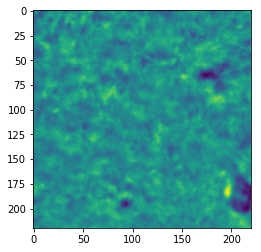

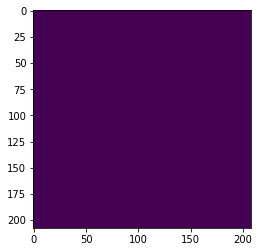

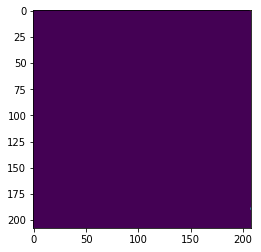

In [0]:
import matplotlib.pyplot as plt
self = DataGenerator(partition['train'],**params)

data = self.__getitem__(2)
self.dataset_path = DATASET_PATH
ID = 'video_10_000002.tif'
aux_x = sitk.ReadImage(self.dataset_path + '/input/input/'+ ID)
aux_x = sitk.GetArrayFromImage(aux_x)
aux_x = np.transpose(aux_x,[0,2,1]) # x dimensions (z,x,y)
aux_x = aux_x.reshape((aux_x.shape[0], aux_x.shape[1],aux_x.shape[2],1))

aux_y = sitk.ReadImage(self.dataset_path + '/output/output/'+ ID)
aux_y = sitk.GetArrayFromImage(aux_y)
aux_y = np.transpose(aux_y,[1,0]) # y dimensions (x,y)
aux_y = aux_y.reshape((1, aux_y.shape[0],aux_y.shape[1], 1))   

# plt.imshow(aux_x[10,:,:,0])
# plt.show()
# plt.imshow(aux_y[0,:,:,0])
# plt.show()
seed = np.random.randint(100000)
random_crop_size_input = (220,220)
random_crop_size_output = (208,208)
c = 0
input_channel, output_channel = random_crop(aux_x[:,:,:,c], aux_y[:,:,:,c], random_crop_size_input, random_crop_size_output, sync_seed=seed)
input_channel = (input_channel-np.min(input_channel))/(np.max(input_channel)-np.min(input_channel))

plt.imshow(input_channel[10,:,:])
plt.show()
plt.imshow(output_channel[0,:,:])
plt.show()

input_channel_i = np.transpose(input_channel,[1,2,0])
input_channel_i = input_channel_i.reshape((1, input_channel_i.shape[0], input_channel_i.shape[1], input_channel_i.shape[2]))
p = model.predict(input_channel_i)
plt.imshow(p[0,:,:,0])
plt.show()
